In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Dropout , BatchNormalization
from keras.activations import relu , softmax , tanh
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class PINN:
    def __init__(self, x, t, hidden_layers=5, hidden_size=50, input_dim=2, activation='tanh', lr=1e-3, epochs=1000):
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size
        self.input_dim = input_dim
        self.activation = activation
        self.x = x
        self.t = t
        self.lr = lr
        self.epochs = epochs
        self.model = self.ann_model()
        self.optimizer = self.defOptimizer()

        # Splitting data
        x_train, x_test, t_train, t_test = train_test_split(self.x, self.t, train_size=0.8, random_state=42)
        self.x_train = tf.convert_to_tensor(x_train.reshape(-1, 1), dtype=tf.float32)
        self.x_test = tf.convert_to_tensor(x_test.reshape(-1, 1), dtype=tf.float32)
        self.t_train = tf.convert_to_tensor(t_train.reshape(-1, 1), dtype=tf.float32)
        self.t_test = tf.convert_to_tensor(t_test.reshape(-1, 1), dtype=tf.float32)

        # Boundary Conditions
        self.t_b = tf.convert_to_tensor(np.linspace(0, 1, 500).reshape(-1, 1), dtype=tf.float32)
        self.x_0 = tf.zeros((500, 1), dtype=tf.float32)
        self.x_pi = tf.convert_to_tensor(np.full((500, 1), np.pi), dtype=tf.float32)
        self.x_b = tf.convert_to_tensor(np.linspace(0.1, np.pi, 500).reshape(-1, 1), dtype=tf.float32)
        self.t_0 = tf.zeros((500, 1), dtype=tf.float32)
        self.act_b = tf.convert_to_tensor(np.sin(self.x_b.numpy()), dtype=tf.float32)

    def ann_model(self):
        model = keras.Sequential()
        model.add(keras.layers.InputLayer(input_shape=(self.input_dim,)))
        for _ in range(self.hidden_layers):
            model.add(keras.layers.Dense(self.hidden_size, activation=self.activation))
        model.add(keras.layers.Dense(1))
        return model

    def call_model(self, x, t):
        xy = tf.concat([x, t], axis=1)
        return self.model(xy)

    def loss_func(self):
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(self.t_train)
            tape1.watch(self.x_train)
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(self.x_train)
                tape.watch(self.t_train)
                u_values = self.call_model(self.x_train, self.t_train)
            du_dx = tape.gradient(u_values, self.x_train)
            du_dt = tape.gradient(u_values, self.t_train)

        d2u_dx2 = tape1.gradient(du_dx, self.x_train)
        d2u_dt2 = tape1.gradient(du_dt, self.t_train)

        # Boundary Conditions
        u_0 = self.call_model(self.x_0, self.t_b)
        u_pi = self.call_model(self.x_pi, self.t_b)

        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(self.x_b)
            tape2.watch(self.t_0)
            u_x_0 = self.call_model(self.x_b, self.t_0)
        du_dt_0 = tape2.gradient(u_x_0, self.t_0)

        c1 = tf.reduce_mean(tf.square(d2u_dt2 - 4 * d2u_dx2))
        b1 = tf.reduce_mean(tf.square(u_0))
        b2 = tf.reduce_mean(tf.square(u_pi))
        b3 = tf.reduce_mean(tf.square(du_dt_0 - self.act_b))
        b4 = tf.reduce_mean(tf.square(u_x_0))
        return c1 + b1 + b2 + b3 + b4

    def train(self):
        with tf.GradientTape(persistent=True) as tape:
            loss_value = self.loss_func()
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss_value

    def defOptimizer(self):
        lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=self.lr,
            decay_steps=1000,
            decay_rate=0.9
        )
        return tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

    def training(self):
        for epoch in range(self.epochs + 1):
            loss_val = self.train()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss_val.numpy()}')
    def plotPredictedActualWaveFunction(self):
      # Define the actual wave function u(x, t) = (1/2) * sin(2t) * sin(x)
      def wave_function(x, t):
          return 0.5 * np.sin(2 * t) * np.sin(x)

      # Generate meshgrid for x and t
      X, T = np.meshgrid(self.x_test.numpy(), self.t_test.numpy())

      # Flatten the meshgrid to create input data for the model
      x_flat = X.flatten().reshape(-1, 1)
      t_flat = T.flatten().reshape(-1, 1)

      # Convert to TensorFlow tensors
      x_flat_tensor = tf.convert_to_tensor(x_flat, dtype=tf.float32)
      t_flat_tensor = tf.convert_to_tensor(t_flat, dtype=tf.float32)

      # Call the model with the flattened input to predict U_pred
      U_pred_flat = self.call_model(x_flat_tensor, t_flat_tensor)
      U_pred = U_pred_flat.numpy().reshape(X.shape)  # Reshape to match meshgrid shape

      # Compute the actual wave function U
      U_actual = wave_function(X, T)

      # Plot the actual and predicted wave functions side by side
      fig = plt.figure(figsize=(14, 6))

      # Plot the actual wave function
      ax1 = fig.add_subplot(121, projection='3d')
      surf1 = ax1.plot_surface(X, T, U_actual, cmap='viridis', edgecolor='k', alpha=0.8)
      ax1.set_title("Actual Wave Function $u(x,t)$", fontsize=14)
      ax1.set_xlabel("$x$", fontsize=12)
      ax1.set_ylabel("$t$", fontsize=12)
      ax1.set_zlabel("$u(x,t)$", fontsize=12)
      fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label="$u(x,t)$")

      # Plot the predicted wave function
      ax2 = fig.add_subplot(122, projection='3d')
      surf2 = ax2.plot_surface(X, T, U_pred, cmap='plasma', edgecolor='k', alpha=0.8)
      ax2.set_title("Predicted Wave Function $u_{\mathrm{pred}}(x,t)$", fontsize=14)
      ax2.set_xlabel("$x$", fontsize=12)
      ax2.set_ylabel("$t$", fontsize=12)
      ax2.set_zlabel("$u_{\mathrm{pred}}(x,t)$", fontsize=12)
      fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10, label="$u_{\mathrm{pred}}(x,t)$")

      plt.tight_layout()
      plt.show()

    def contourPlots(self):
      # Define the actual wave function u(x, t) = (1/2) * sin(2t) * sin(x)
      def wave_function(x, t):
          return 0.5 * np.sin(2 * t) * np.sin(x)

      # Generate meshgrid for x and t
      X, T = np.meshgrid(self.x_test.numpy(), self.t_test.numpy())

      # Flatten the meshgrid to create input data for the model
      x_flat = X.flatten().reshape(-1, 1)
      t_flat = T.flatten().reshape(-1, 1)

      # Convert to TensorFlow tensors
      x_flat_tensor = tf.convert_to_tensor(x_flat, dtype=tf.float32)
      t_flat_tensor = tf.convert_to_tensor(t_flat, dtype=tf.float32)

      # Call the model with the flattened input to predict U_pred
      U_pred_flat = self.call_model(x_flat_tensor, t_flat_tensor)
      U_pred = U_pred_flat.numpy().reshape(X.shape)  # Reshape to match meshgrid shape

      # Compute the actual wave function U
      U_actual = wave_function(X, T)

      fig, ax = plt.subplots(1, 3, figsize=(18, 6))
      contour1 = ax[0].contourf(X, T, U_actual, cmap='viridis')
      ax[0].set_title("Actual Wave Function $u(x,t)$", fontsize=14)
      ax[0].set_xlabel("$x$", fontsize=12)
      ax[0].set_ylabel("$t$", fontsize=12)
      fig.colorbar(contour1, ax=ax[0], label="$u(x,t)$")

      # Predicted wave function
      contour2 = ax[1].contourf(X, T, U_pred, cmap='plasma')
      ax[1].set_title("Predicted Wave Function $u_{\mathrm{pred}}(x,t)$", fontsize=14)
      ax[1].set_xlabel("$x$", fontsize=12)
      ax[1].set_ylabel("$t$", fontsize=12)
      fig.colorbar(contour2, ax=ax[1], label="$u_{\mathrm{pred}}(x,t)$")

      # Absolute difference
      diff = np.abs(U_actual - U_pred)
      contour3 = ax[2].contourf(X, T, diff, cmap='coolwarm')
      ax[2].set_title("Absolute Difference $|u(x,t) - u_{\mathrm{pred}}(x,t)|$", fontsize=14)
      ax[2].set_xlabel("$x$", fontsize=12)
      ax[2].set_ylabel("$t$", fontsize=12)
      fig.colorbar(contour3, ax=ax[2], label="Difference")

      plt.tight_layout()
      plt.show()

In [ ]:
x = np.linspace(0,3.4,1000)
t = np.linspace(0 , 1 , 1000)

# ***Training 1***

In [ ]:
obj = PINN(x,t)

In [ ]:
obj.training()

Epoch 0, Loss: 0.5672504901885986
Epoch 100, Loss: 0.018002081662416458
Epoch 200, Loss: 0.0036865470465272665
Epoch 300, Loss: 0.0024774610064923763
Epoch 400, Loss: 0.002074571792036295
Epoch 500, Loss: 0.0007914562593214214
Epoch 600, Loss: 0.0004166553553659469
Epoch 700, Loss: 0.005988802295178175
Epoch 800, Loss: 0.00021492739324457943
Epoch 900, Loss: 0.0001938454806804657
Epoch 1000, Loss: 0.0001867769460659474


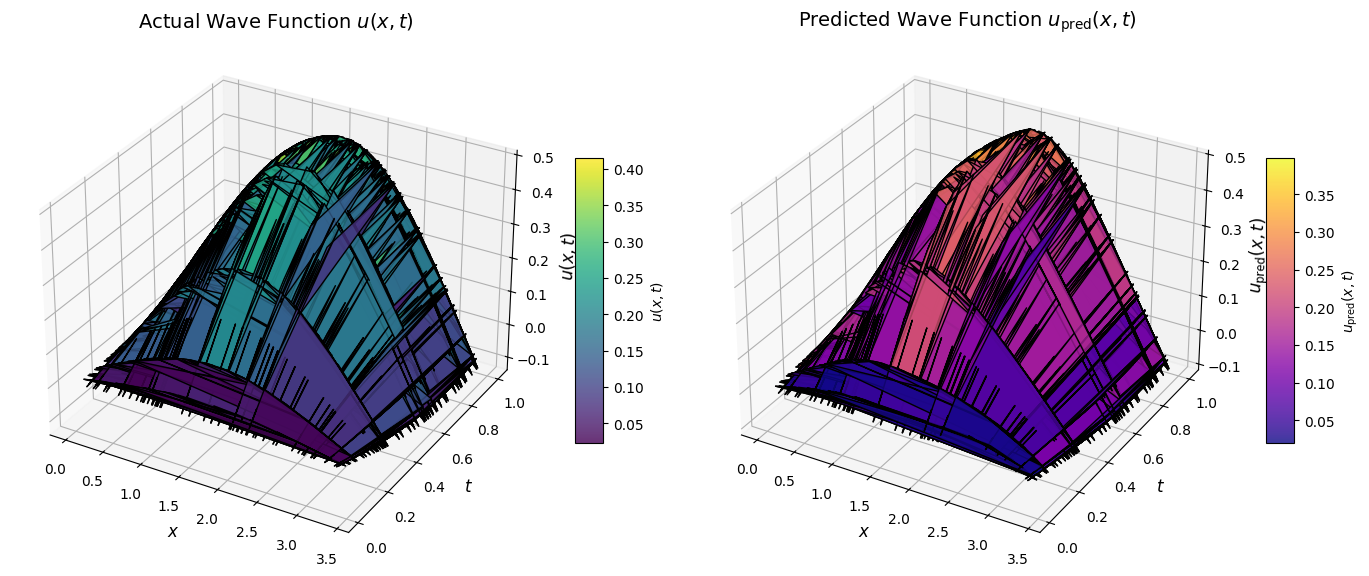

In [ ]:
obj.plotPredictedActualWaveFunction()

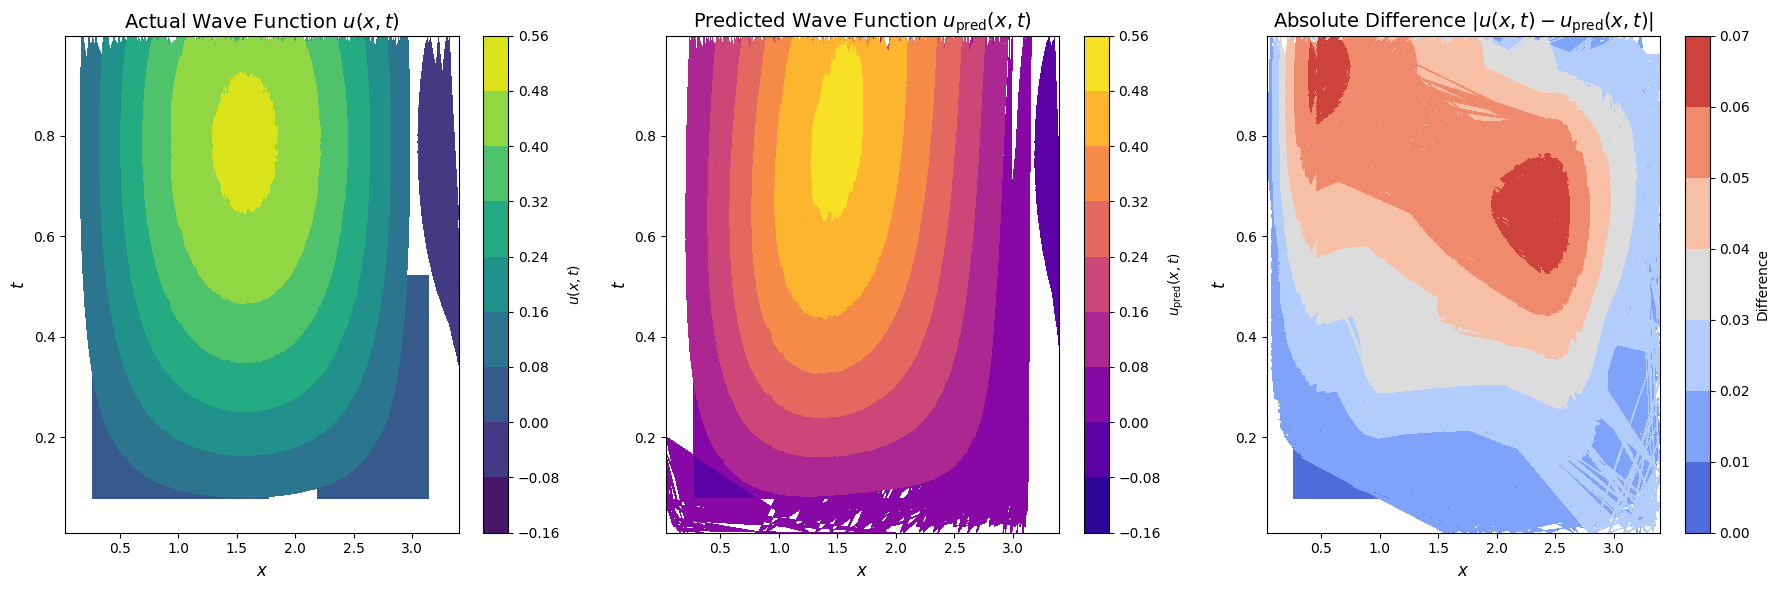

In [ ]:
obj.contourPlots()

# ***Training 2***

In [ ]:
obj2 = PINN(x,t , epochs = 3000) ## Changing the epochs

In [ ]:
obj2.training()

Epoch 0, Loss: 1.574522614479065
Epoch 100, Loss: 0.14990586042404175
Epoch 200, Loss: 0.013247472234070301
Epoch 300, Loss: 0.003713388927280903
Epoch 400, Loss: 0.0025243619456887245
Epoch 500, Loss: 0.0018318829825147986
Epoch 600, Loss: 0.0013851223047822714
Epoch 700, Loss: 0.000917922705411911
Epoch 800, Loss: 0.0006839039269834757
Epoch 900, Loss: 0.0004578429798129946
Epoch 1000, Loss: 0.00082763796672225
Epoch 1100, Loss: 0.0002601287851575762
Epoch 1200, Loss: 0.00019624806009232998
Epoch 1300, Loss: 0.003801547223702073
Epoch 1400, Loss: 0.00014054912026040256
Epoch 1500, Loss: 0.00011952205386478454
Epoch 1600, Loss: 0.0001064068783307448
Epoch 1700, Loss: 0.00013489510456565768
Epoch 1800, Loss: 9.317514195572585e-05
Epoch 1900, Loss: 8.611564408056438e-05
Epoch 2000, Loss: 8.274901483673602e-05
Epoch 2100, Loss: 0.00029335060389712453
Epoch 2200, Loss: 7.258975529111922e-05
Epoch 2300, Loss: 6.745005521224812e-05
Epoch 2400, Loss: 0.00014012547035235912
Epoch 2500, Loss: 

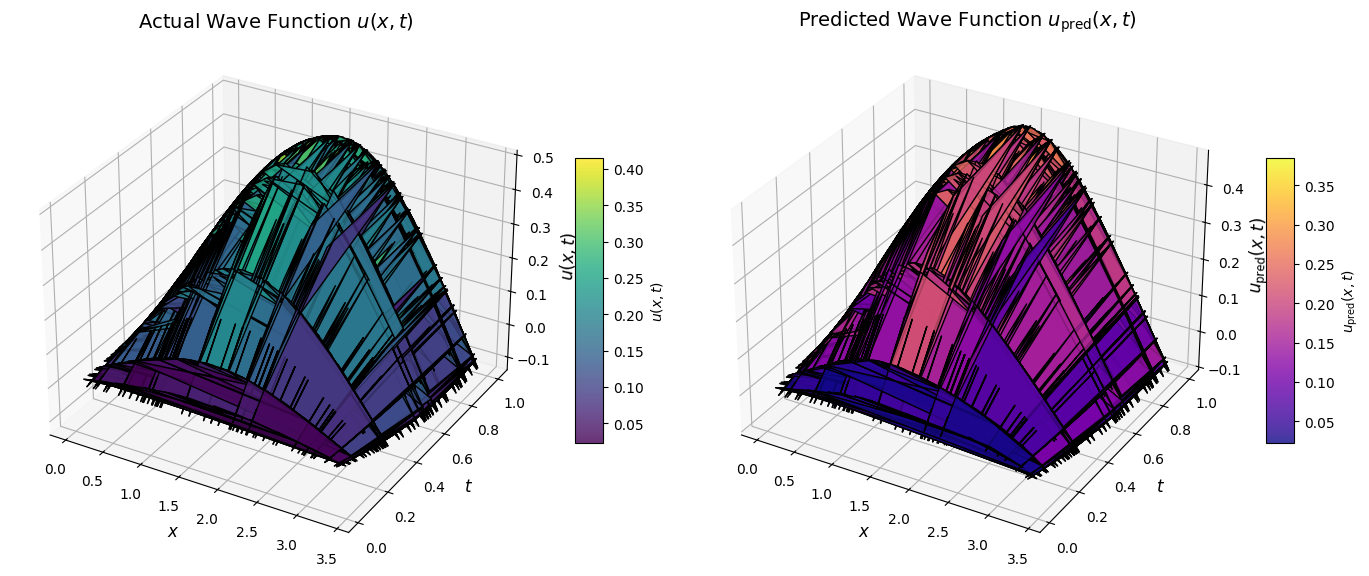

In [ ]:
obj2.plotPredictedActualWaveFunction()

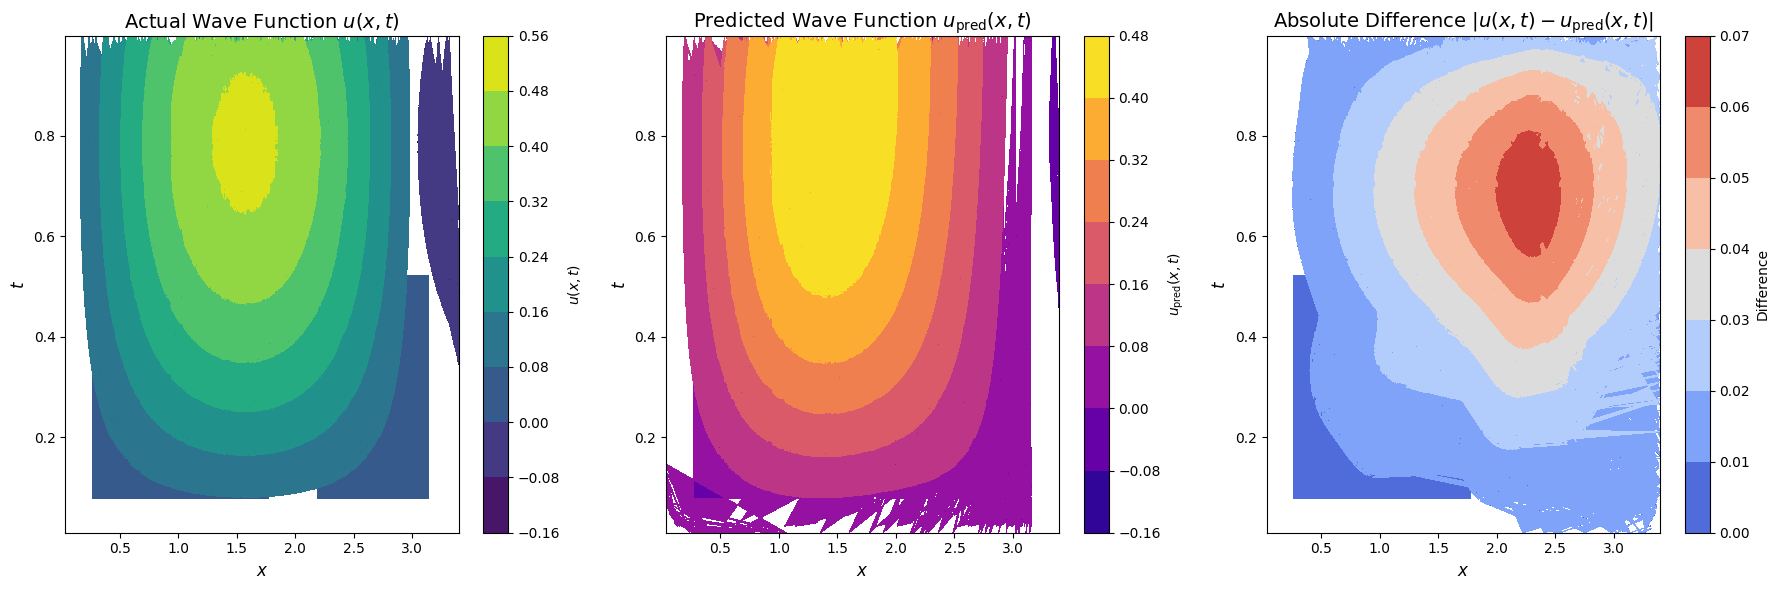

In [ ]:
obj2.contourPlots()

# ***Training 3***

In [ ]:
obj3 = PINN(x,t , epochs = 3000 , hidden_size = 20 , hidden_layers = 7) ## Changing the epochs along with hidden size and hidden layers

In [ ]:
obj3.training()

Epoch 0, Loss: 1.215139627456665
Epoch 100, Loss: 0.06766492128372192
Epoch 200, Loss: 0.029926722869277
Epoch 300, Loss: 0.011816495098173618
Epoch 400, Loss: 0.00393690075725317
Epoch 500, Loss: 0.0033920553978532553
Epoch 600, Loss: 0.0020246761851012707
Epoch 700, Loss: 0.0016239096876233816
Epoch 800, Loss: 0.0013254927471280098
Epoch 900, Loss: 0.0010935327736660838
Epoch 1000, Loss: 0.0009210321586579084
Epoch 1100, Loss: 0.0014672665856778622
Epoch 1200, Loss: 0.0005915038054808974
Epoch 1300, Loss: 0.0005165755283087492
Epoch 1400, Loss: 0.0003848624764941633
Epoch 1500, Loss: 0.00034583397791720927
Epoch 1600, Loss: 0.00026170132332481444
Epoch 1700, Loss: 0.0002313651639269665
Epoch 1800, Loss: 0.0030815936625003815
Epoch 1900, Loss: 0.0012293144827708602
Epoch 2000, Loss: 0.00013423686323221773
Epoch 2100, Loss: 0.0006256479537114501
Epoch 2200, Loss: 0.0003053935943171382
Epoch 2300, Loss: 9.326907456852496e-05
Epoch 2400, Loss: 0.0025477197486907244
Epoch 2500, Loss: 7.66

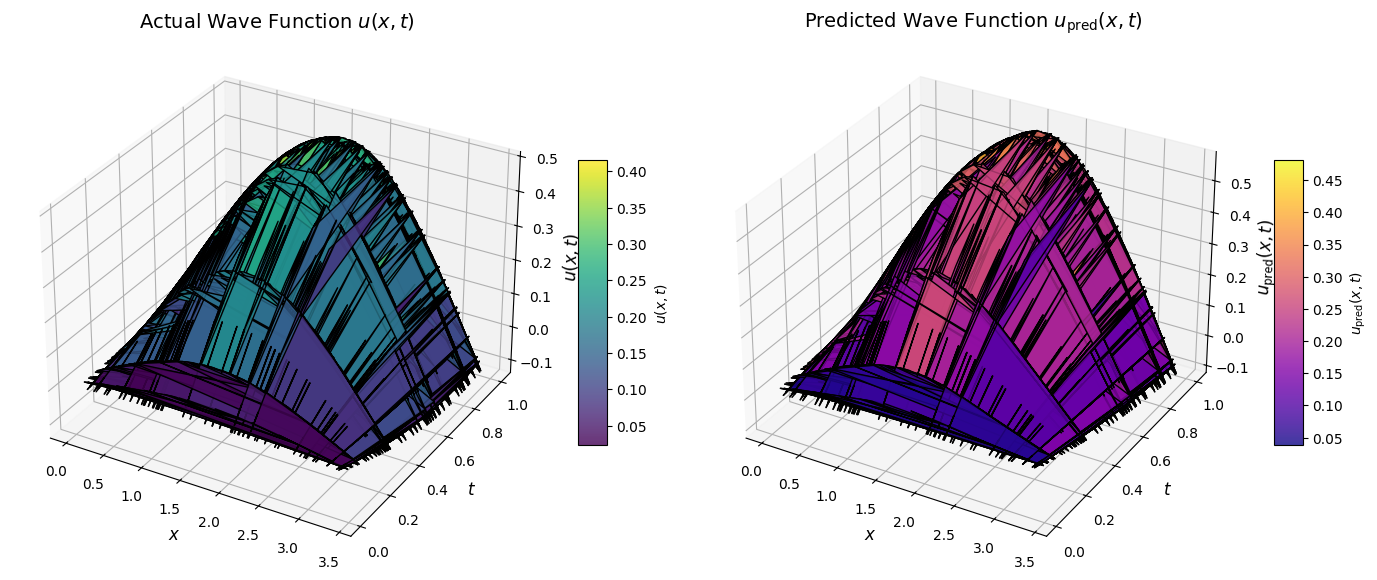

In [ ]:
obj3.plotPredictedActualWaveFunction()

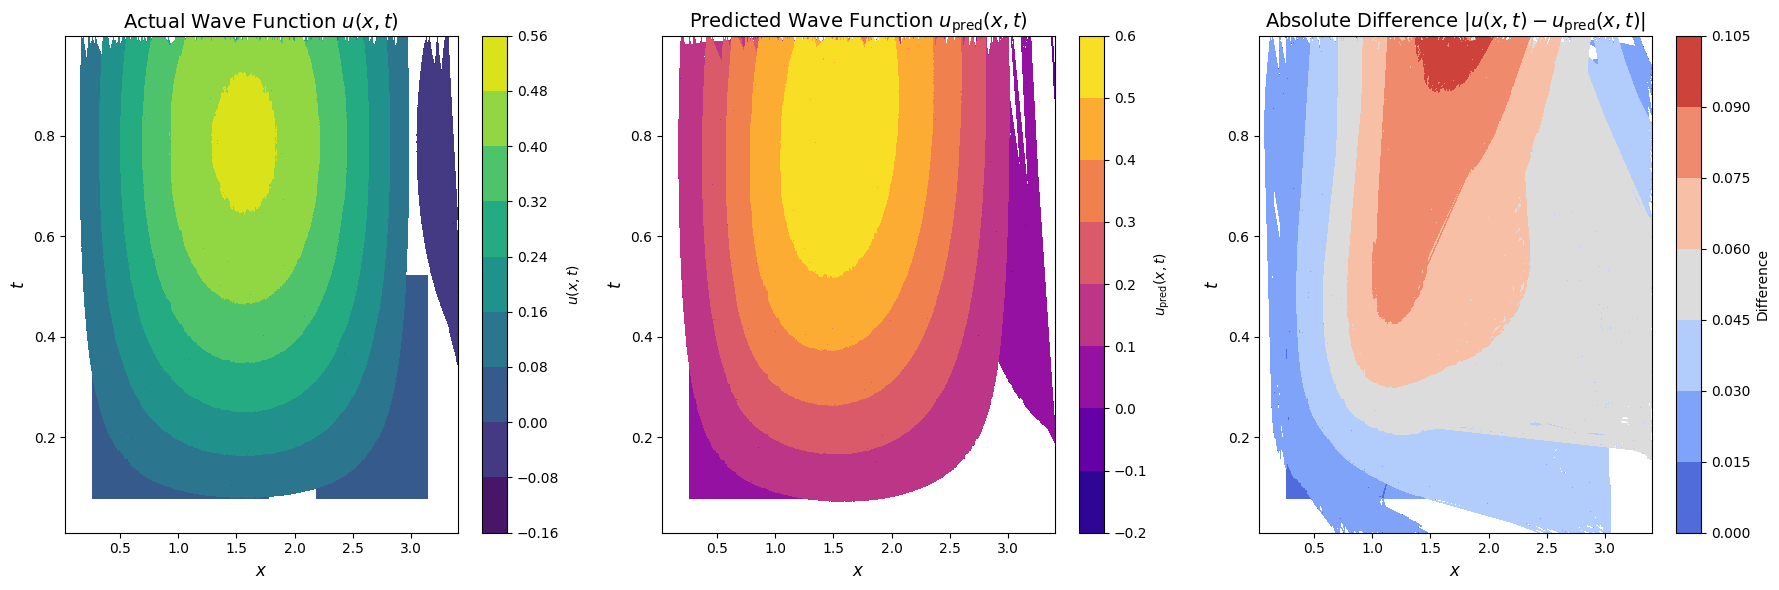

In [ ]:
obj3.contourPlots()